# New Start with

In [ ]:
# install dependencies: (use cu101 because colab has CUDA 10.1)

!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html

!pip install cython pyyaml==5.1

!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

import torch, torchvision

print(torch.__version__, torch.cuda.is_available())

!gcc — version

# opencv is pre-installed on colab

# install detectron2:

!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 703.8/703.8 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 60.3 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 1.13.1+cu116
    Uninstalling torch-1.13.1+cu116:
      Successfully uninstalled torch-1.13.1+cu116
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.14.1+cu116
    Uninstalling torchvision-0.14.1+cu116:
      Successfully uninstalled torchvision-0.14.1+cu116
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.14.1 requires torch==1.13.1, but you have torch 1.5.0+cu101 which is incompatible.
torchaudio 0.13.1+cu116 requires t

In [ ]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger

import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.data.catalog import DatasetCatalog

## Import and Register Custom Detectron2 Data

In [ ]:
!wget https://moderncomputervision.s3.eu-west-2.amazonaws.com/North+American+Mushrooms.v1-416x416.coco.zip
!unzip -q "North+American+Mushrooms.v1-416x416.coco.zip"
!curl -L “https://public.roboflow.com/ds/6lksQTPxfb?key=FMnBpxKVpK" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

--2023-03-06 16:47:20--  https://moderncomputervision.s3.eu-west-2.amazonaws.com/North+American+Mushrooms.v1-416x416.coco.zip
Resolving moderncomputervision.s3.eu-west-2.amazonaws.com (moderncomputervision.s3.eu-west-2.amazonaws.com)... 52.95.150.134
Connecting to moderncomputervision.s3.eu-west-2.amazonaws.com (moderncomputervision.s3.eu-west-2.amazonaws.com)|52.95.150.134|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1761052 (1.7M) [application/zip]
Saving to: ‘North+American+Mushrooms.v1-416x416.coco.zip’

North+American+Mush 100%[===================>]   1.68M  1.38MB/s    in 1.2s    

2023-03-06 16:47:22 (1.38 MB/s) - ‘North+American+Mushrooms.v1-416x416.coco.zip’ saved [1761052/1761052]

/bin/bash: -c: line 0: unexpected EOF while looking for matching `"'
/bin/bash: -c: line 1: syntax error: unexpected end of file


In [ ]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "/content/train/_annotations.coco.json", "/content/train")
register_coco_instances("my_dataset_val", {}, "/content/valid/_annotations.coco.json", "/content/valid")
register_coco_instances("my_dataset_test", {}, "/content/test/_annotations.coco.json", "/content/test")

#visualize training data

WARNING [03/06 16:47:23 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[03/06 16:47:23 d2.data.datasets.coco]: Loaded 41 images in COCO format from /content/train/_annotations.coco.json


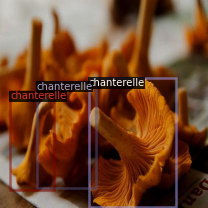

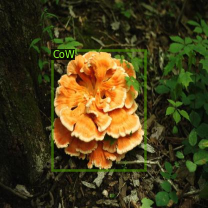

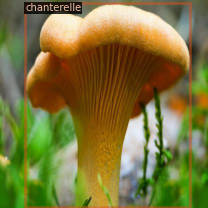

In [ ]:
my_dataset_train_metadata = MetadataCatalog.get("my_dataset_train")
dataset_dicts = DatasetCatalog.get("my_dataset_train")
import random
from detectron2.utils.visualizer import Visualizer
for d in random.sample(dataset_dicts, 3):
  img = cv2.imread(d["file_name"])
  visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
  vis = visualizer.draw_dataset_dict(d)
  cv2_imshow(vis.get_image()[:, :, ::-1])


Train Custom Detectron2 Detector
#We are importing our own Trainer Module here to use the COCO validation evaluation during training. Otherwise no validation eval occurs.

In [12]:
 from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator
class CocoTrainer(DefaultTrainer):
  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):
    if output_folder is None:
      os.makedirs("coco_eval", exist_ok=True)
      output_folder = "coco_eval"
    return COCOEvaluator(dataset_name, cfg, False, output_folder)
#from .detectron2.tools.train_net import Trainer
#from detectron2.engine import DefaultTrainer
# select from modelzoo here: https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md#coco-object-detection-baselines
from detectron2.config import get_cfg
#from detectron2.evaluation.coco_evaluation import COCOEvaluator
import os
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml") # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 1500 #adjust up if val mAP is still rising, adjust down if overfit
cfg.SOLVER.STEPS = (1000, 1500)
cfg.SOLVER.GAMMA = 0.05
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4 #your number of classes + 1
cfg.TEST.EVAL_PERIOD = 500
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CocoTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[03/06 16:47:27 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_68b088.pkl: 421MB [00:25, 16.7MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[03/06 16:48:00 d2.engine.train_loop]: Starting training from iteration 0
[03/06 16:48:38 d2.utils.events]:  eta: 0:46:19  iter: 19  total_loss: 2.458  loss_cls: 1.549  loss_box_reg: 0.920  loss_rpn_cls: 0.005  loss_rpn_loc: 0.007  time: 1.8652  data_time: 0.0329  lr: 0.000020  max_mem: 7238M
[03/06 16:49:17 d2.utils.events]:  eta: 0:46:49  iter: 39  total_loss: 2.133  loss_cls: 1.193  loss_box_reg: 0.911  loss_rpn_cls: 0.003  loss_rpn_loc: 0.006  time: 1.9175  data_time: 0.0161  lr: 0.000040  max_mem: 7238M
[03/06 16:49:57 d2.utils.events]:  eta: 0:46:50  iter: 59  total_loss: 1.657  loss_cls: 0.726  loss_box_reg: 0.920  loss_rpn_cls: 0.007  loss_rpn_loc: 0.006  time: 1.9402  data_time: 0.0167  lr: 0.000060  max_mem: 7238M
[03/06 16:50:37 d2.utils.events]:  eta: 0:46:31  iter: 79  total_loss: 1.405  loss_cls: 0.533  loss_box_reg: 0.873  loss_rpn_cls: 0.005  loss_rpn_loc: 0.006  time: 1.9548  data_time: 0.0202  lr: 0.000080  max_mem: 7238M
[03/06 16:51:16 d2.utils.events]:  eta: 0:46:0

In [13]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard — logdir output
#test evaluation
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85
predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator("my_dataset_test", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "my_dataset_test")
inference_on_dataset(trainer.model, val_loader, evaluator)


ERROR: Failed to launch TensorBoard (exited with 2).
Contents of stderr:
2023-03-06 17:39:24.978743: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.8/dist-packages/cv2/../../lib64:/usr/lib64-nvidia
2023-03-06 17:39:24.978861: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.8/dist-packages/cv2/../../lib64:/usr/lib64-nvidia
2023-03-06 17:39:24.978874: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are inst

WARNING [03/06 17:39:29 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[03/06 17:39:29 d2.data.datasets.coco]: Loaded 5 images in COCO format from /content/test/_annotations.coco.json
[03/06 17:39:29 d2.data.build]: Distribution of instances among all 3 categories:
|  category  | #instances   |  category  | #instances   |  category   | #instances   |
|:----------:|:-------------|:----------:|:-------------|:-----------:|:-------------|
|  mushroom  | 0            |    CoW     | 1            | chanterelle | 8            |
|            |              |            |              |             |              |
|   total    | 9            |            |              |             |              |
[03/06 17:39:29 d2.data.common]: Serializing 5 elements to byte tensors and concatenating them all ...
[03/06 17:39:29 d2.data.common]: Serialized dataset takes 0.00 MiB
[03/06 17:39:29 d2.evaluation.evaluator]: Start inference on 5

OrderedDict([('bbox',
              {'AP': 91.78076379066478,
               'AP50': 93.56435643564357,
               'AP75': 93.56435643564357,
               'APs': nan,
               'APm': nan,
               'APl': 91.78076379066478,
               'AP-mushroom': nan,
               'AP-CoW': 99.99999999999997,
               'AP-chanterelle': 83.56152758132956})])

Inference with Detectron2 Saved Weights

coco_instances_results.json                        last_checkpoint
events.out.tfevents.1678121255.50f7480ee37f.774.0  metrics.json
instances_predictions.pth                          model_final.pth


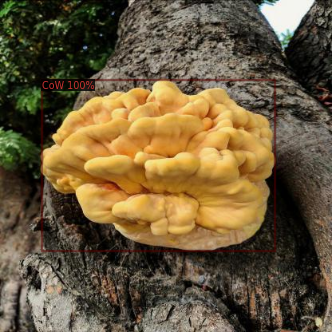

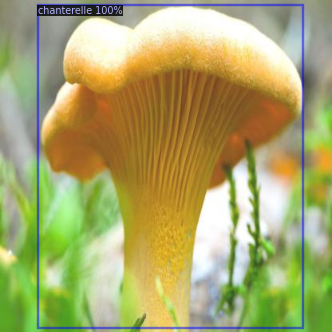

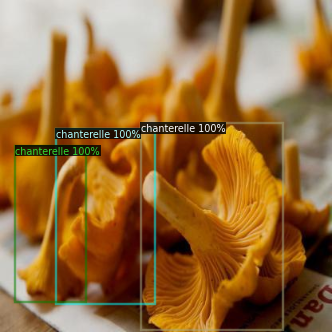

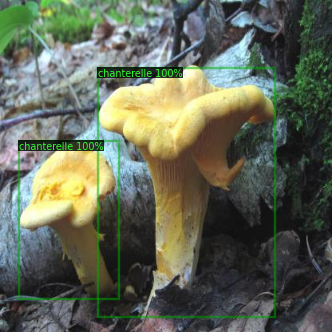

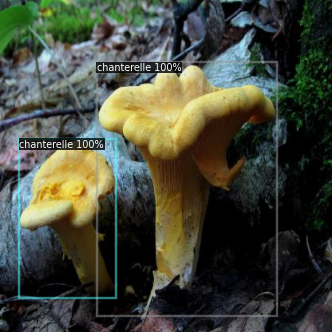

In [15]:
%ls ./output/
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.DATASETS.TEST = ("my_dataset_test", )
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7 # set the testing threshold for this model
predictor = DefaultPredictor(cfg)
test_metadata = MetadataCatalog.get("my_dataset_test")
from detectron2.utils.visualizer import ColorMode
import glob
for imageName in glob.glob('/content/test/*jpg'):
  im = cv2.imread(imageName)
  outputs = predictor(im)
  v = Visualizer(im[:, :, ::-1], metadata=test_metadata, scale=0.8)

  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

  cv2_imshow(out.get_image()[:, :, ::-1])